# Install MQTT Library

With Conda (if you are using Anaconda)

In [ ]:
import sys
!conda install -y -p {sys.prefix} -c conda-forge paho-mqtt

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.7.1




With Pip

In [ ]:
!pip install paho-mqtt

Verify that we have the library properly installed

The following code block should not generate an error

In [ ]:
import paho.mqtt.client as mqtt

# Parameters

In [ ]:
# Replace with your matric ID
YOUR_MATRIC_ID = 'A0289393J'
# Note that the sensors publish a reading every few seconds
NUM_SAMPLES = 20000

# The following does not need to be changed
MQTT_HOST = '10.246.112.87'
MQTT_SUBPATH = 'ee4211/'
MQTT_LIGHT_SENSOR = 'light_sensor_0/brightness_lux'
MQTT_TEMP_SENSOR = 'temp_sensor_0/temperature_degC'

# Data Collection

Define callback function used to collect published data

In [ ]:
import json

def parse_json(msg):
    err = False
    try:
        json_object = json.loads(msg)
    except:
        err = True
    else:
        if 'v' not in json_object or 'ts' not in json_object:
            err = True
    if err:
        print('Malformed reading received:', end=' ')
        print(msg)
        return None
    return json_object

light_readings = []
def collect_received_light(c, u, msg):
    msg = parse_json(msg.payload)
    if not msg: return

    # Two columns, 'timestamp' and 'brightness_lux'
    reading = {}
    # The timestamp is contained in msg['ts']
    reading['timestamp'] = msg['ts']
    # The reading is contained in msg['v']
    reading['brightness_lux'] = msg['v']
    # Cast the reading into an integer
    reading['brightness_lux'] = int(reading['brightness_lux'])
    print('Got light reading:', end=' ')
    print(reading)
    # Append it to the 'light_readings' list
    light_readings.append(reading)

temp_readings = []
def collect_received_temp(c, u, msg):
    msg = parse_json(msg.payload)
    if not msg: return

    # Two columns, 'timestamp' and 'temperature_degC'
    reading = {}
    # The timestamp is contained in msg['ts']
    reading['timestamp'] = msg['ts']
    # The reading is contained in msg['v']
    reading['temperature_degC'] = msg['v']
    # Cast the reading into a float
    reading['temperature_degC'] = float(reading['temperature_degC'])
    print('Got temp reading:', end=' ')
    print(reading)
    # Append it to the 'temp_readings' list
    temp_readings.append(reading)

def collect_received(c, u, msg):
    if MQTT_LIGHT_SENSOR in msg.topic:
        collect_received_light(c, u, msg)
    elif MQTT_TEMP_SENSOR in msg.topic:
        collect_received_temp(c, u, msg)

Generate anonymised ID for connection to MQTT server

In [ ]:
import hashlib
MQTT_ID = YOUR_MATRIC_ID.lower().strip()
MQTT_ID = hashlib.sha256(MQTT_ID.encode()).hexdigest()[-16:]

Connect to MQTT server

In [ ]:
import paho.mqtt.client as mqtt
client = mqtt.Client()
# Attach the on_message callback to the collect_received() function
client.on_message = collect_received
client.username_pw_set(username = MQTT_ID, password = MQTT_ID)
client.connect(MQTT_HOST)
client.loop_start()

Subscribe to sensor topics

In [ ]:
# Clear the list of readings first
light_readings = []
temp_readings = []

MQTT_TOPIC = MQTT_SUBPATH + MQTT_ID + '/' + MQTT_LIGHT_SENSOR
client.subscribe(MQTT_TOPIC)
print('Subscribed to topic:', end=' ')
print(MQTT_TOPIC)

MQTT_TOPIC = MQTT_SUBPATH + MQTT_ID + '/' + MQTT_TEMP_SENSOR
client.subscribe(MQTT_TOPIC)
print('Subscribed to topic:', end=' ')
print(MQTT_TOPIC)

Wait for the required number of readings to accumulate and disconnect.

If you do not see any readings being collected within a few seconds, something is wrong. Check that you have your matric id filled in correctly.

In [ ]:
from time import sleep
while len(light_readings) < NUM_SAMPLES or len(temp_readings) < NUM_SAMPLES:
    sleep(1.0)
client.disconnect()
client.loop_stop()

print('Number of light readings obtained:', end=' ')
print(len(light_readings))

print('Number of temp readings obtained:', end=' ')
print(len(temp_readings))

Dump the readings to a JSON file for offline processing

In [ ]:
import json
import time
curr_time = int(time.time())
with open(f'readings_{curr_time}_light.json', 'w') as f:
    json.dump(light_readings, f)
with open(f'readings_{curr_time}_temp.json', 'w') as f:
    json.dump(temp_readings, f)

# Data Processing

Write your data processing functions to answer the questions in the worksheet.

Your normal data visualisation and processing libraries such as seaborn, pandas and numpy are available.

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

import json
from datetime import datetime

def parse_timestamp(ts):
    try:
        # Requires Python 3.7 and above
        ts = datetime.fromisoformat(ts)
    except:
        # Python version does not have fromisoformat(), we continue
        # to represent the timestamp as a string.
        # It is then up to you to properly parse the timestamp in
        # your processing
        pass
    return ts

# Sample that just imports from json and prints all the readings
run_time = curr_time
with open(f'readings_{run_time}_light.json', 'r') as f:
    light_readings = json.load(f)
with open(f'readings_{run_time}_temp.json', 'r') as f:
    temp_readings = json.load(f)

for light_reading in light_readings:
    light_reading['timestamp'] = parse_timestamp(light_reading['timestamp'])
    print('Timestamp:', end=' ')
    print(light_reading['timestamp'], end=' ')
    print('Brightness (lux):', end=' ')
    print(light_reading['brightness_lux'])

for temp_reading in temp_readings:
    temp_reading['timestamp'] = parse_timestamp(temp_reading['timestamp'])
    print('Timestamp:', end=' ')
    print(temp_reading['timestamp'], end=' ')
    print('Temperature (degC):', end=' ')
    print(temp_reading['temperature_degC'])

Average Sunrise Time: 05:21
Average Sunset Time: 19:06
Average Temperature in a Day (°C): 26.123283695040342
Maximum Temperature (°C): 32.418
Minimum Temperature (°C): 21.363


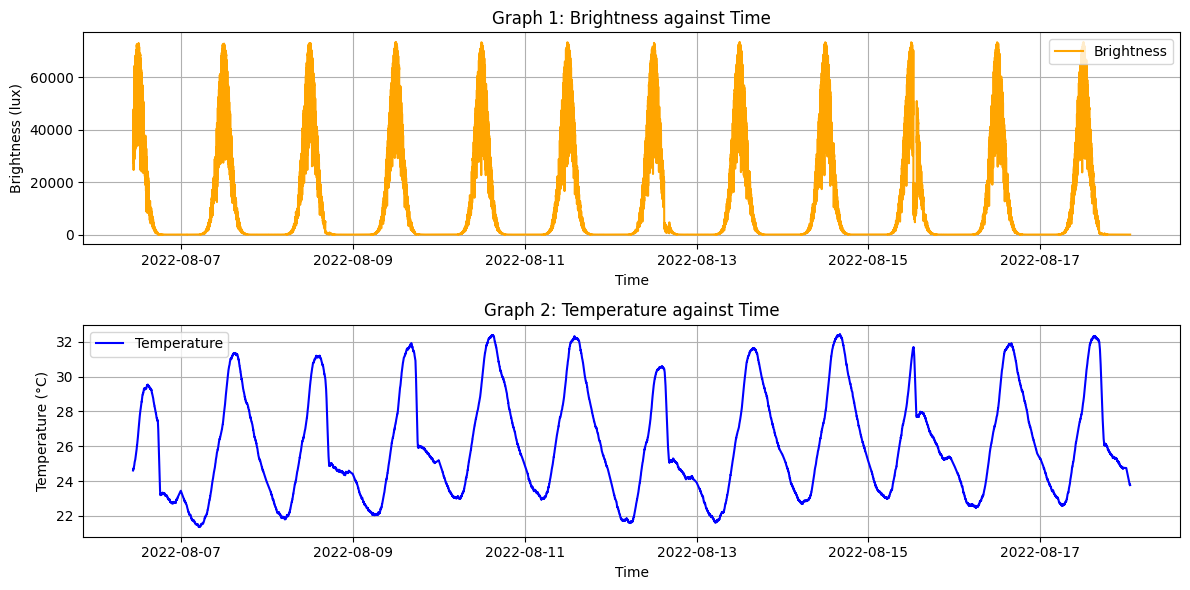

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Load data from JSON files
brightness_data = pd.read_json('/content/readings_1728432165_light.json')
temperature_data = pd.read_json('/content/readings_1728432165_temp.json')

temperature_data.rename(columns={'timestamp': 'Time', 'temperature_degC': 'Temperature'}, inplace=True)
brightness_data.rename(columns={'timestamp': 'Time', 'brightness_lux': 'Brightness'}, inplace=True)

brightness_data['Time'] = pd.to_datetime(brightness_data['Time'])
temperature_data['Time'] = pd.to_datetime(temperature_data['Time'])

brightness_data['Date'] = brightness_data['Time'].dt.date
threshold_brightness = 50
daytime_brightness_data = brightness_data[brightness_data['Brightness'] > threshold_brightness]

sunrise_times = daytime_brightness_data.groupby('Date')['Time'].min()
sunset_times = daytime_brightness_data.groupby('Date')['Time'].max()

def time_to_minutes(t):
    return t.hour * 60 + t.minute

sunrise_minutes = sunrise_times.dt.time.apply(time_to_minutes)
sunset_minutes = sunset_times.dt.time.apply(time_to_minutes)

average_sunrise_minutes = sunrise_minutes.mean()
average_sunset_minutes = sunset_minutes.mean()

average_sunrise_time = (timedelta(minutes=average_sunrise_minutes) % timedelta(days=1)).seconds // 3600, \
                       (timedelta(minutes=average_sunrise_minutes) % timedelta(days=1)).seconds % 3600 // 60

average_sunset_time = (timedelta(minutes=average_sunset_minutes) % timedelta(days=1)).seconds // 3600, \
                      (timedelta(minutes=average_sunset_minutes) % timedelta(days=1)).seconds % 3600 // 60

# Calculate average temperature in a day
average_temperature = temperature_data['Temperature'].mean()

# Find max and min temperatures
max_temperature = temperature_data['Temperature'].max()
min_temperature = temperature_data['Temperature'].min()

print("Average Sunrise Time: {:02d}:{:02d}".format(average_sunrise_time[0], average_sunrise_time[1]))
print("Average Sunset Time: {:02d}:{:02d}".format(average_sunset_time[0], average_sunset_time[1]))
print("Average Temperature in a Day (°C):", average_temperature)
print("Maximum Temperature (°C):", max_temperature)
print("Minimum Temperature (°C):", min_temperature)

#Brightness against Time
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(brightness_data['Time'], brightness_data['Brightness'], label='Brightness', color='orange')
plt.title('Graph 1: Brightness against Time')
plt.xlabel('Time')
plt.ylabel('Brightness (lux)')
plt.grid(True)
plt.legend()

#Temperature against Time
plt.subplot(2, 1, 2)
plt.plot(temperature_data['Time'], temperature_data['Temperature'], label='Temperature', color='blue')
plt.title('Graph 2: Temperature against Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-2-899c6341901c>:88: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_times = pd.date_range(start=times.iloc[-1] + timedelta(minutes=1), periods=future_steps, freq='T')


Model 1 (Temp History) MAE: 0.0123
Model 2 (Brightness History) MAE: 2.4580
Model 3 (Temp + Brightness History) MAE: 0.0138


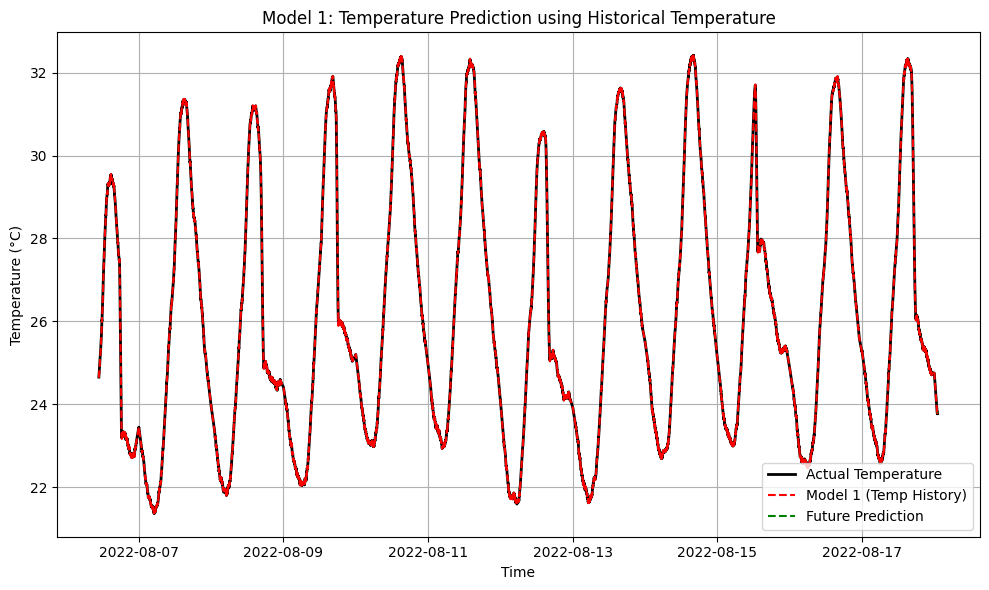

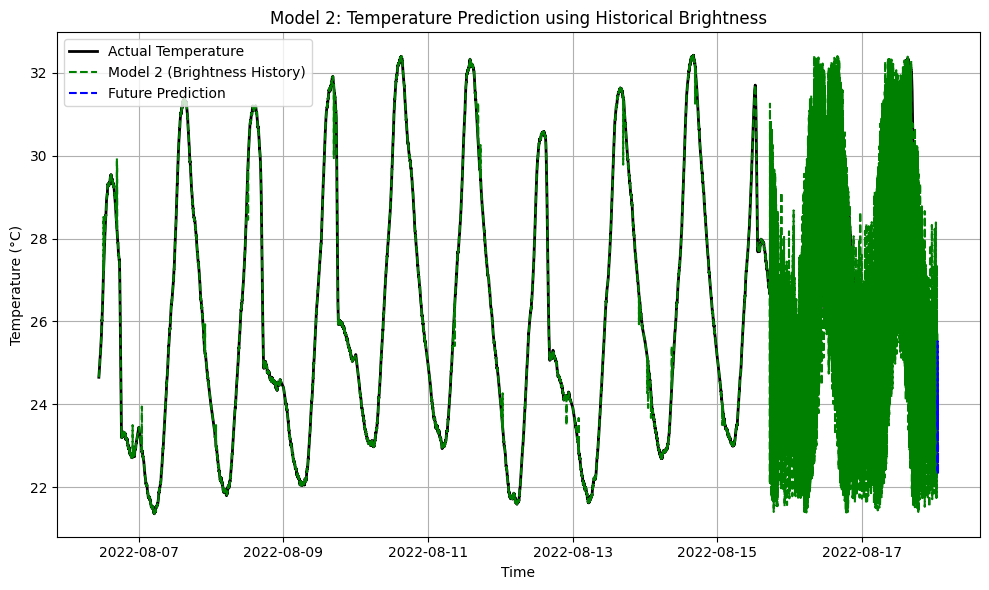

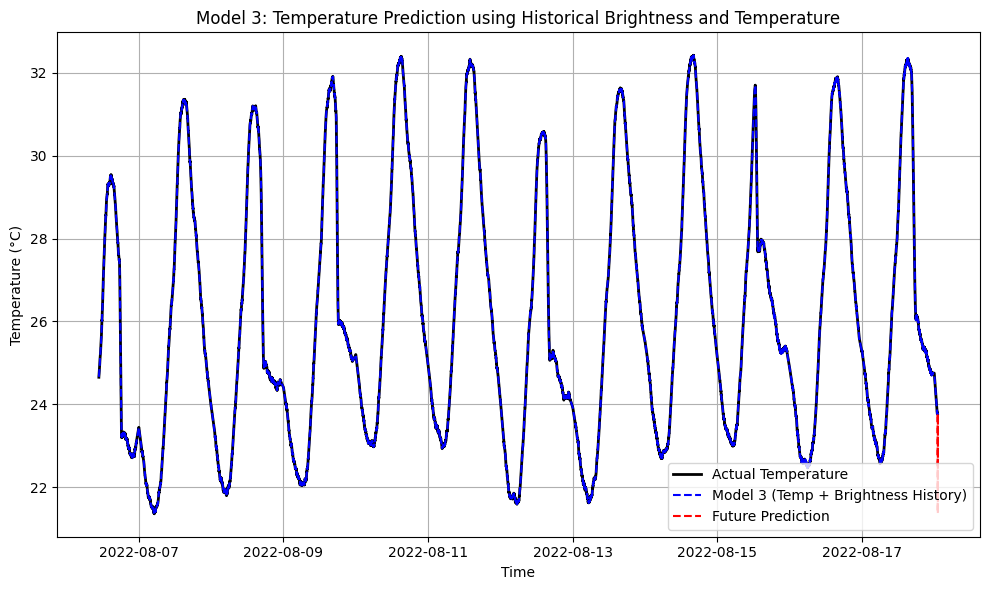

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

# Load data
brightness_data = pd.read_json('/content/readings_1728432165_light.json')
temperature_data = pd.read_json('/content/readings_1728432165_temp.json')

temperature_data.rename(columns={'timestamp': 'Time', 'temperature_degC': 'Temperature'}, inplace=True)
brightness_data.rename(columns={'timestamp': 'Time', 'brightness_lux': 'Brightness'}, inplace=True)

temperature_data['Time'] = pd.to_datetime(temperature_data['Time'])
brightness_data['Time'] = pd.to_datetime(brightness_data['Time'])

data = pd.merge(temperature_data, brightness_data, on='Time')

def create_lagged_features(df, column, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[column].values[i-window_size:i])
        y.append(df['Temperature'].values[i])
    return np.array(X), np.array(y)

window_size = 5

# Model 1: Historical temperature as X, current temperature as Y
X_temp, y_temp = create_lagged_features(temperature_data, 'Temperature', window_size)

# Model 2: Historical brightness as X, current temperature as Y
X_brightness, y_brightness = create_lagged_features(data, 'Brightness', window_size)

# Model 3: Historical brightness and temperature as X, current temperature as Y
X_temp_hist, _ = create_lagged_features(data, 'Temperature', window_size)
X_brightness_hist, _ = create_lagged_features(data, 'Brightness', window_size)
X_both = np.hstack((X_temp_hist, X_brightness_hist))

# Split data into training and testing sets
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=False)
X_brightness_train, X_brightness_test, y_brightness_train, y_brightness_test = train_test_split(X_brightness, y_brightness, test_size=0.2, shuffle=False)
X_both_train, X_both_test, y_both_train, y_both_test = train_test_split(X_both, y_temp, test_size=0.2, shuffle=False)

# Model 1: Linear Regression on temperature
model1 = LinearRegression()
model1.fit(X_temp_train, y_temp_train)

# Model 2: Decision Tree Regressor on brightness
model2 = DecisionTreeRegressor()
model2.fit(X_brightness_train, y_brightness_train)

# Model 3: Random Forest Regressor on brightness and temperature
model3 = RandomForestRegressor()
model3.fit(X_both_train, y_both_train)

y_pred_temp = model1.predict(np.vstack((X_temp_train, X_temp_test)))
y_pred_brightness = model2.predict(np.vstack((X_brightness_train, X_brightness_test)))
y_pred_both = model3.predict(np.vstack((X_both_train, X_both_test)))

def future_prediction(model, last_window, future_steps):
    future_preds = []
    window = last_window.copy() 
    for _ in range(future_steps):
        pred = model.predict([window])[0]
        future_preds.append(pred)
        window = np.append(window[1:], pred) 
    return future_preds

future_steps = 10
future_pred_temp = future_prediction(model1, X_temp_test[-1], future_steps)
future_pred_brightness = future_prediction(model2, X_brightness_test[-1], future_steps)
future_pred_both = future_prediction(model3, X_both_test[-1], future_steps)

times = data['Time'][window_size:]
future_times = pd.date_range(start=times.iloc[-1] + timedelta(minutes=1), periods=future_steps, freq='T')

mae_temp = mean_absolute_error(y_temp_test, y_pred_temp[-len(y_temp_test):])
mae_brightness = mean_absolute_error(y_brightness_test, y_pred_brightness[-len(y_brightness_test):])
mae_both = mean_absolute_error(y_both_test, y_pred_both[-len(y_both_test):])

print(f"Model 1 (Temp History) MAE: {mae_temp:.4f}")
print(f"Model 2 (Brightness History) MAE: {mae_brightness:.4f}")
print(f"Model 3 (Temp + Brightness History) MAE: {mae_both:.4f}")

# Plot 1: Model 1 - Historical Temperature + Future Prediction
plt.figure(figsize=(10, 6))
plt.plot(times, data['Temperature'][window_size:], label='Actual Temperature', color='black', linewidth=2)
plt.plot(times, y_pred_temp, label='Model 1 (Temp History)', color='red', linestyle='--')
plt.plot(future_times, future_pred_temp, label='Future Prediction', color='green', linestyle='--')
plt.title('Model 1: Temperature Prediction using Historical Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Model 2 - Historical Brightness + Future Prediction
plt.figure(figsize=(10, 6))
plt.plot(times, data['Temperature'][window_size:], label='Actual Temperature', color='black', linewidth=2)
plt.plot(times, y_pred_brightness, label='Model 2 (Brightness History)', color='green', linestyle='--')
plt.plot(future_times, future_pred_brightness, label='Future Prediction', color='blue', linestyle='--')
plt.title('Model 2: Temperature Prediction using Historical Brightness')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Model 3 - Historical Brightness and Temperature + Future Prediction
plt.figure(figsize=(10, 6))
plt.plot(times, data['Temperature'][window_size:], label='Actual Temperature', color='black', linewidth=2)
plt.plot(times, y_pred_both, label='Model 3 (Temp + Brightness History)', color='blue', linestyle='--')
plt.plot(future_times, future_pred_both, label='Future Prediction', color='red', linestyle='--')
plt.title('Model 3: Temperature Prediction using Historical Brightness and Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
